# Dubins car navigating in a cluttered environment

This script shows an example of trajectory obtained with SCP. 
The problem consists of computing a trajectory avoiding obstacles and minimizing control effort.
The final time is a free optimization variable.

In [1]:
# If first time running this code on a personal computer
# using Pkg
# Pkg.instantiate()

### Script / SCP Initialization

In [2]:
# Initializing script
using LinearAlgebra
using Ipopt
using JuMP

include("./Models/dubins_free.jl")
include("./SCP/scp_problem.jl")
include("./utils/dubins_plotting.jl")

# Number of time-discretization points and maximum number of SCP iterations
N, max_it = 41, 10

# Defining the model, the initial strategy and each convex subproblem
model   = DubinsFree()
Xp,Up   = initialize_trajectory(model,N)
problem = SCPProblem(model,N,Xp,Up)

model.tf_guess = 6.0
model.k = 5.
model.x_init  = [0;0;pi/3]
model.x_final = [3;3;pi/2.5]
model.B_free_final_time  = true
model.B_free_final_angle = true

model.obstacles = []
obs = [[0.7,0.9],0.3]
push!(model.obstacles, obs)
obs = [[0.7,1.5],0.4]
push!(model.obstacles, obs)
obs = [[1.5,1.2],0.3]
push!(model.obstacles, obs)
obs = [[1.8,0.65],0.45]
push!(model.obstacles, obs)
obs = [[2.0,2.85],0.45]
push!(model.obstacles, obs)
obs = [[2.1,2.2],0.3]
push!(model.obstacles, obs)

# Defining SCP parameters
(Delta0, omega0, omegamax, epsilon,
        convergence_threshold) = get_initial_scp_parameters(model)

# plt_solutions(problem, model, X_all, U_all)

(3.0, 5000.0, 1.0e6, 0.001, 0.001)

## SCP

In [3]:
# Defining penalization weights, trust-region radius and the list of solutions
include("SCP/scp_problem.jl")
include("./Models/dubins_free.jl")
Xp,Up        = initialize_trajectory(model,N)
X, U         = copy(Xp), copy(Up)
omega, Delta = omega0, Delta0
X_all, U_all = [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

# SCP loop
success, it = false, 1
while it < max_it                                                               && 
      !(success && convergence_metric(model,X,U,Xp,Up) < convergence_threshold) &&
      omega < omegamax
    println("-----------\nIteration $it\n-----------")
    
    # Storing the solution at the previous step and the linearized dynamics
    Xp, Up                    = copy(X), copy(U)
    model.f, model.A, model.B = compute_dynamics(model,Xp,Up)
    
    # Defining the convex subproblem
    reset_problem(problem, model)
    set_parameters(problem, model, Xp, Up, omega, Delta)
    define_nonconvex_cost(problem, model)
    define_constraints(problem, model)
    
    # Solving the convex subproblem
    JuMP.optimize!(problem.solver_model)
    X_sol, U_sol = JuMP.value.(problem.X), JuMP.value.(problem.U)
    println("tf=",X_sol[end,end])
    
    X, U    = copy(X_sol), copy(U_sol)
    Delta   = 0.99 * Delta
    success = true

    # Collecting the solution at each iteration
    push!(X_all,copy(X))
    push!(U_all,copy(U))
    it += 1
    
    println("Parameters:")
    println("omega  = $omega; Delta = $Delta")
    println("metric = $(convergence_metric(model,X,U,Xp,Up))")
end

print(">>> Finished <<<")

-----------
Iteration 1
-----------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

tf=3.977511857746387
Parameters:
omega  = 5000.0; Delta = 2.9699999999999998
metric = 0.013952693181237399
-----------
Iteration 2
-----------
tf=4.484600413970671
Parameters:
omega  = 5000.0; Delta = 2.9402999999999997
metric = 0.01228120511296515
-----------
Iteration 3
-----------
tf=4.538042092039851
Parameters:
omega  = 5000.0; Delta = 2.910897
metric = 0.0005551822997573061
>>> Finished <<<

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = plt_solutions(::SCPProblem, ::DubinsFree, ::Array{Any,1}, ::Array{Any,1}; xlims::Array{Float64,1}, ylims::Array{Float64,1}, figsize::Tuple{Int64,Int64}, B_plot_labels::Bool) at dubins_plotting.jl:63
└ @ Main /home/thomas/Documents/research/jlscp/utils/dubins_plotting.jl:63


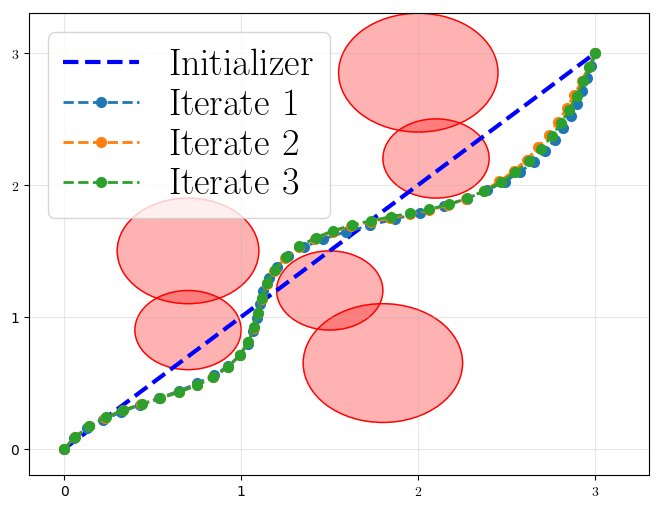

Done Plotting

In [4]:
include("./utils/dubins_plotting.jl")
plt_solutions(problem, model, X_all, U_all)
plt.xlim([-0.2, 3.3])
plt.ylim([-0.2, 3.3])
print("Done Plotting")

In [5]:
tf_all = [X_all[iter_i][end,end] for iter_i in 1:length(X_all)]

4-element Array{Float64,1}:
 6.0
 3.977511857746387
 4.484600413970671
 4.538042092039851